# Data Sources for Text Summarization

In this notebook I look at 3 different datasets commonliy referenced for text summarization problems. 

1. CNN/Daily Mail (Over 300,000 news articles)
1. Reddit TL;DR (Over 3,800,000 Reddit posts)
1. Wikihow (Over 200,000 articles)

The CNN/Daily Mail dataset seems to be one of the most popular data sets for text summarization problems and is frequently used as a benchmark dataset. The Reddit TL;DR datset also looks attractive due to its size. There is potential to find ways to filter out lower quality summaries to then improve the text summarization problem. 

## CNN/Daily Mail

[This link](https://cs.nyu.edu/~kcho/DMQA/) is a good starting point if you want to download the data. It is also avaliable via Tensorflow Datasets [here](https://github.com/abisee/cnn-dailymail). This dataset is one of the most commonly referenced datasets when it comes to text summarization problems. 

The idea behind this dataset is that there are news articles from CNN and Daily Mail, within the news articles there are highlights. These highlights are parts of the article that are displayed more prominently and generally have important details from the article. When you just look at these highlights it can often look like a summary of the article.   

The Tensorflow Dataset version already has the article and summary separated and it is easier to download and extract programatically.

There are over 311,000 articles with some sort of generated summary in this dataset. 

In [1]:
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib
%config InlineBackend.figure_format = 'retina'

news, info = tfds.load('cnn_dailymail', with_info=True, shuffle_files=True)

In [2]:
info

tfds.core.DatasetInfo(
    name='cnn_dailymail',
    version=3.0.0,
    description='CNN/DailyMail non-anonymized summarization dataset.

There are two features:
  - article: text of news article, used as the document to be summarized
  - highlights: joined text of highlights with <s> and </s> around each
    highlight, which is the target summary',
    homepage='https://github.com/abisee/cnn-dailymail',
    features=FeaturesDict({
        'article': Text(shape=(), dtype=tf.string),
        'highlights': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=311971,
    splits={
        'test': 11490,
        'train': 287113,
        'validation': 13368,
    },
    supervised_keys=('article', 'highlights'),
    citation="""@article{DBLP:journals/corr/SeeLM17,
      author    = {Abigail See and
                   Peter J. Liu and
                   Christopher D. Manning},
      title     = {Get To The Point: Summarization with Pointer-Generator Networks},
      journal   = {Co

In [3]:
def convert_tensors_strings(df):
    for c in df.columns:
        df[c] = df[c].map(lambda x: x.numpy().decode())

news_train  = news['train'].take(2)
news_df = pd.DataFrame(news_train)
convert_tensors_strings(news_df)
pd.set_option('display.max_colwidth', None)
news_df

,article,highlights
0,"QPR chairman Tony Fernandes has insisted his club can afford not to win promotion to the Premier League, despite debts of £177.1 million. Rangers face Derby County in the Championship play-off final at Wembley on May 24, with Harry Redknapp's side hoping to secure the £120m pay packet of Premier League promotion. But, should QPR return to the top tier at the first attempt, they could be forced to pay out more than half of that in fines under the Football League's Financial Fair Play regulations. We're ready: Queens Park Rangers chairman Tony Fernandes says his club doesn't have to win promotion . Off to Wembley: Rangers won their way through to the play-off final after extra-time against Wigan . Based on last year's accounts, Rangers would have to pay £62.1m if they are promoted because their £65.4m losses were so far in excess of the £8m allowed by the Football League. Should Redknapp's side stay in the Championship, however, they would be subjected to a transfer embargo. QPR have tried to reduce their wage bill by selling high-earners such as Christopher Samba and sending the likes of Loic Remy and Adel Taarabt out on loan. Improved: Businessman Fernandes says QPR are in a better financial position than two years ago . Winner: QPR striker Charlie Austin finds the net to snatch the victory in the play-off second leg . Fernandes told talkSPORT: 'Yes, we can (afford not to go up). I'm an accountant by background - although I may not seem it! 'We've told the fans, whether we go up or we don't, we're here for the long term. 'We know what culture we want at the club and we will continue the journey whether we're in the Championship or the Premier League. 'We are a much smarter, much wiser group of people than we were two years ago.' Relief: QPR's bid to reduce their wage bills included off-loading players such as Christopher Samba . Major break: Loic Remy (right) went on loan to Newcastle and scored 14 goals for Alan Pardew's side .",Queens Park Rangers have debts of £177.1 million .\nThe club is also set to be hit with fines under Financial Fair Play rules .\nBut chairman Tony Fernandes says they can survive without winning promotion to the Premier League this season .\nQPR take on Derby in the play-off final at Wembley on May 24 .
1,"By . Daily Mail Reporter . UPDATED: . 09:53 EST, 12 January 2012 . A motorist was stunned when he discovered double yellow lines had been painted underneath his car while it was parked - and then given a ticket. Flecks of yellow paint were even sprayed on the bumper of Patrick McCrystal's car as the lines were painted under the front of it in Kedleston Street, Derby. The 49-year-old had parked his Ford Fiesta in the street near to a Co-operative store and a petrol station, where he works, for three years. Stunned: Patrick McCrystal with his Ford Fiesta, which was given a ticket after council workmen had sprayed yellow lines under the car while it was parked legally . When he parked for his 2pm shift, he noticed new yellow lines had been painted across a housing block entrance. But there was a gap between those lines and existing ones in the street, so Mr McCrystal parked there, in his usual spot. Hours later, a colleague on his dinner break saw that extra lines had been painted below the front of Mr McCrystal's car. And, when he went out, Mr McCrystal discovered he had been given a parking ticket. Tell-tale sign: The workmen left flecks of paint on the bumper of the car as they sprayed underneath . He said: 'There is even paint on my front bumper where they've caught it reaching under to paint the lines. 'There were no lines there when I parked. I can't believe they've done it.' The new lines extended from existing double yellow lines which had previously ended about two feet from Mr McCrystal's front bumper. Apology: The ticket left on Mr McCrystal's window. Derby City Council blamed a breakdown in communication and has now revoked the £70 fine . Now a Derby City Council offi

## Next let's see how much data we have here. 

In [4]:
from pyspark.ml.feature import RegexTokenizer
from pyspark.sql import functions as F
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /home/jzeimen/dev/ecosystem/spark/spark-tensorflow-connector/target/spark-tensorflow-connector_2.12-1.11.0.jar pyspark-shell'
from pyspark.sql.functions import lower, col
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Summarization") \
        .master("local[*]") \
        .config("spark.jars", "/home/jzeimen/dev/ecosystem/spark/spark-tensorflow-connector/target/spark-tensorflow-connector_2.12-1.11.0.jar")\
        .config("spark.driver.memory", "25g")\
        .getOrCreate()

In [5]:
news_sdf = spark.read.format("tfrecords").load("/home/jzeimen/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0/cnn*")

In [6]:
news_sdf.count()

311971

In [7]:
def add_token_counts(sdf, content_column, summary_column):
    content_tokenizer = RegexTokenizer(inputCol=content_column, outputCol="content_tokens", pattern='\\W')
    summary_tokenizer = RegexTokenizer(inputCol=summary_column, outputCol="summary_tokens", pattern='\\W')
    sdf = content_tokenizer.transform(sdf)
    sdf = summary_tokenizer.transform(sdf)
    sdf = sdf.withColumn("content_token_count", F.size(sdf.content_tokens))
    sdf = sdf.withColumn("summary_token_count", F.size(sdf.summary_tokens))
    return sdf

In [8]:
news_sdf = add_token_counts(news_sdf, "article", "highlights")

In [9]:
news_pdf = news_sdf.select("content_token_count", "summary_token_count").toPandas()

In [10]:
news_pdf.describe()

,content_token_count,summary_token_count
count,311971.000000,311971.000000
mean,697.847229,49.927230
std,339.476293,21.159507
min,8.000000,3.000000
25%,446.000000,37.000000
50%,636.000000,47.000000
75%,885.000000,58.000000
max,2209.000000,1476.000000


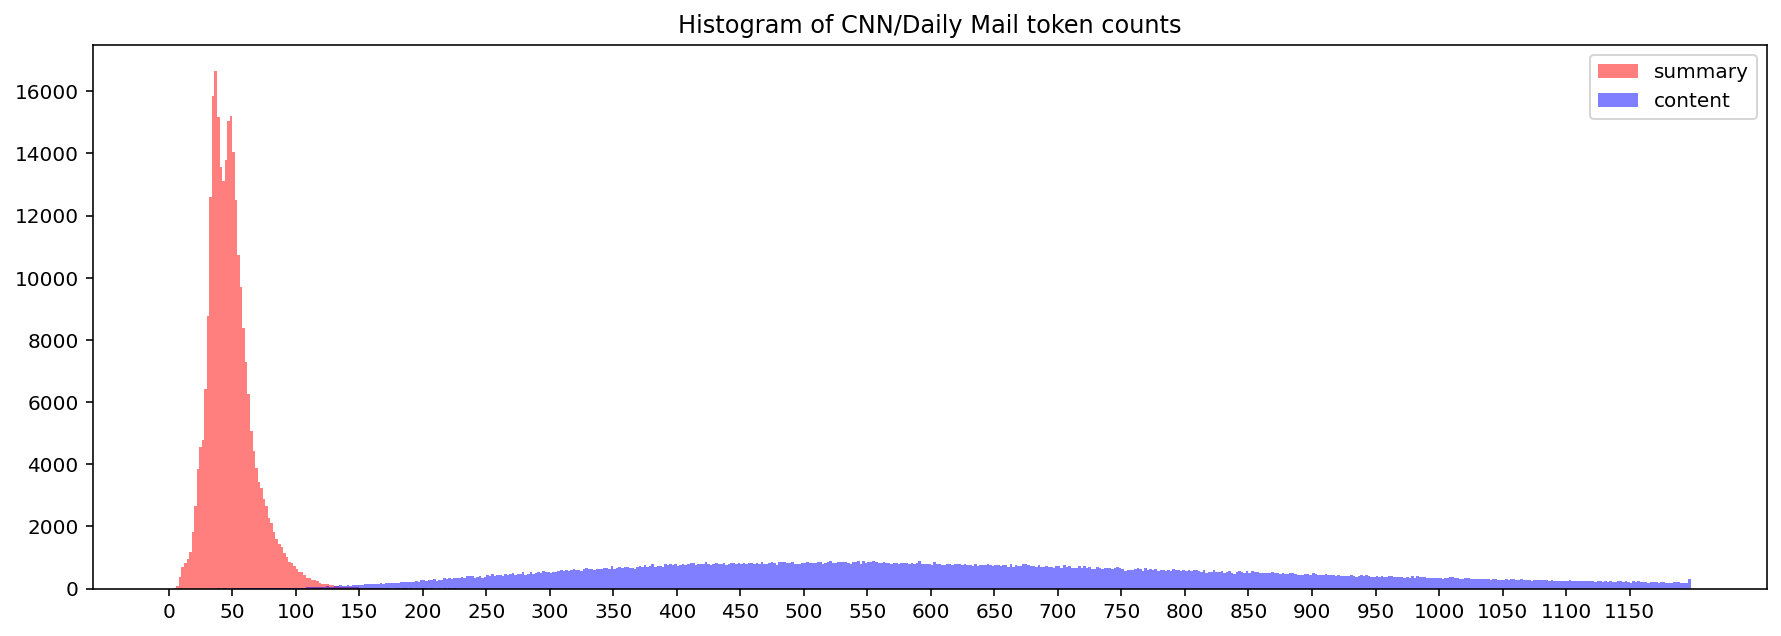

In [11]:
import matplotlib.pyplot as plt
import numpy as np
min_count = 0
max_count = 1200
bins = np.linspace(min_count, max_count, 600, endpoint=False, dtype=int)
plt.figure(figsize=(15,5))
plt.hist(news_pdf.where(news_pdf.content_token_count < max_count).summary_token_count, bins = bins, color='red', alpha=0.5, label='summary', log=False)
plt.hist(news_pdf.where(news_pdf.content_token_count < max_count).content_token_count, bins = bins, color='blue', alpha=0.5, label='content', log=False)
plt.legend()
plt.xticks(np.arange(min_count, max_count, 50))

plt.title("Histogram of CNN/Daily Mail token counts")
plt.show();

We can clearly see that the content has a very wide range of lengths while the summaries are much sorter.

## Reddit TL;DR Dataset

This data set can also be downloaded from [Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/reddit). 

The idea behind this dataset is that people posting to reddit may write a long post. At the end they add "TL;DR" followed by a summary of what they just posted. "TL;DR" simply means "To long; didn't read." Originally this was a critisizm of a long post, now this has become a popular way to signal that you are going to summarize the meaning of the post so others can choose to read the whole thing or not.

The data is nice for summarization, because these are intended to be actual summaries unlike the other datasets I am showing here which are re-purposing other parts of the articles for a substitue for the summarization. This dataset also has over 3 million records. It is also much less formal. We may be able to see if some subreddits have better summaries than others. 

In [12]:
reddit_sdf = spark.read.format("tfrecords").load("/home/jzeimen/tensorflow_datasets/reddit/1.0.0/reddit*")

In [13]:
reddit_sdf.count()

3848330

In [14]:
reddit_sdf.limit(3).toPandas()[['content', 'summary']]

,content,summary
0,"I recently had my swing analyzed at a local Dick's Sporting Goods. The sales rep told me that out of 6 swings I had two at 86 mph, one at 87 mph, two at 96 mph and one at 100 mph. The first three were the lowest which he attributed to not being loose, which makes sense. Also, I have a terrible slice off the tee that I would like to control. I am fairly new to the game and I am looking to get my own set of clubs as I am currently using my dad's. The trouble is, I don't know which shaft flex to get. The clubs I am leaning towards are Adams, which I have read typically are not as stiff as they are rated. But I want to make the right decision. Any advice?",I'm new to the game of golf and need advice on what shaft flex to use.
1,"A few hours ago I was browsing one of my usual subreddits when I noticed a post made by a random person using a nickname familiar to me. At first I had a hint of both curiosity and disbelief, I mean no way this redditor could be them out of the millions of accounts on here but there is that what-if feeling in the back of my mind. \n Dumbshit me decides to click on the user's post history...Ya, it is them. I figured I might as well see what they were posting while we were together.The account turned into posts of nude pics and comments of how they were with multiple partners. Awesome.",Reddit helped confirm why my ex is my ex.
2,"I am from Picon. I was raised there, and love life there. I say I want to move to Caprica to experience the largess and affluence, but in reality Picon is my home. I might go Caprica to study at their fine schools, but I'll always want to go back home to Picon, which always feels like home. \n When the cylons attacked, I was on a transport from Caprica back home to visit family. We didn't have an F","ive, so when the fleet left, I was abandoned. My last memory was watching the twins of Caprica and Gemenon cross Helios Alpha. Then the cylon raiders came."


In [15]:
reddit_sdf = add_token_counts(reddit_sdf, "content", "summary")
reddit_sdf = reddit_sdf.select("content_token_count", "summary_token_count", "subreddit")

In [16]:
reddit_pdf = reddit_sdf.toPandas()

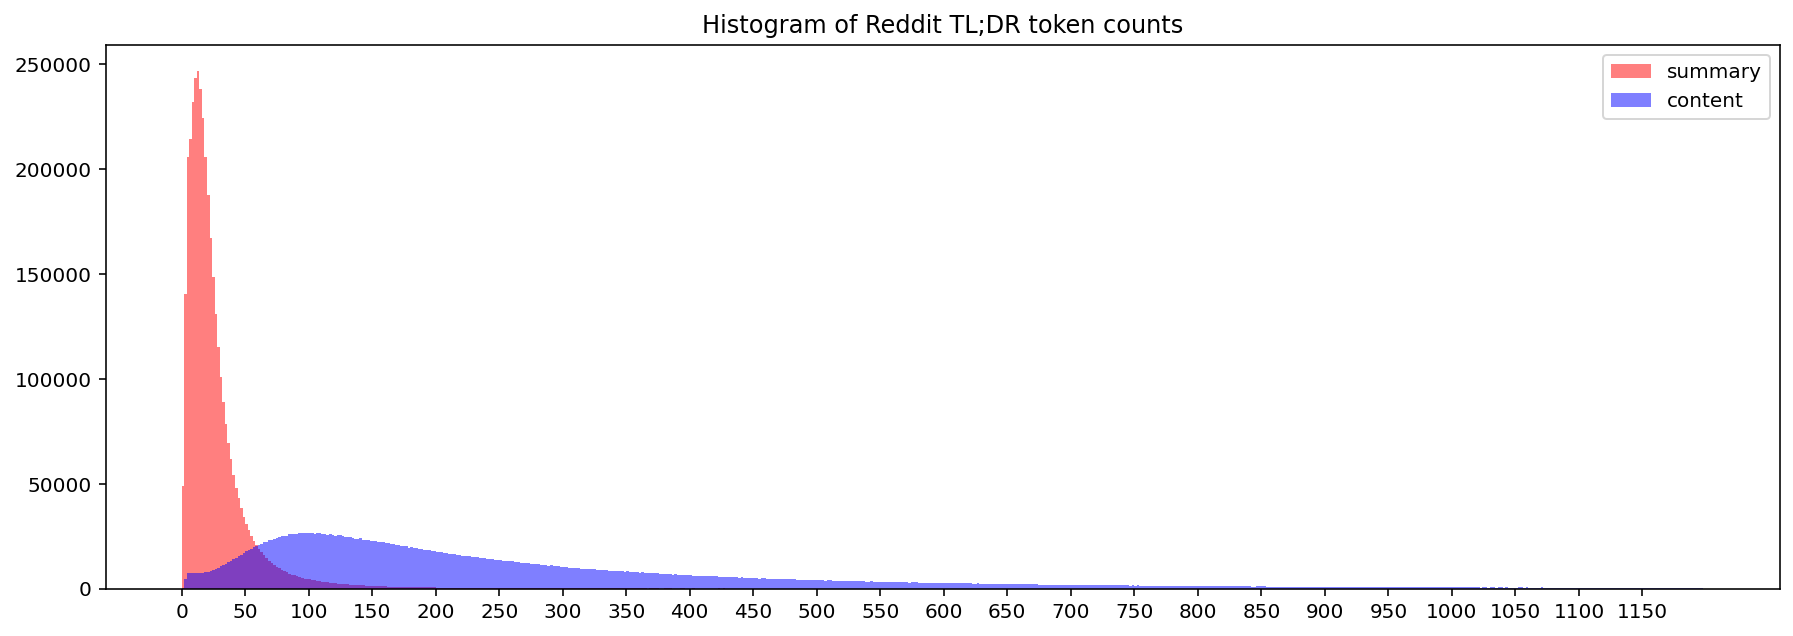

In [17]:
min_count = 0
max_count = 1200
plt.figure(figsize=(15,5))
bins = np.linspace(min_count, max_count, 600, endpoint=False, dtype=int)
plt.hist(reddit_pdf.where(reddit_pdf.content_token_count < max_count).summary_token_count, bins = bins, color='red', alpha=0.5, label='summary', log=False)
plt.hist(reddit_pdf.where(reddit_pdf.content_token_count < max_count).content_token_count, bins = bins, color='blue', alpha=0.5, label='content', log=False)
plt.legend()
plt.xticks(np.arange(min_count, max_count, 50))

plt.title("Histogram of Reddit TL;DR token counts")
plt.show();

In [18]:
reddit_sdf.groupby("subreddit").count().sort("count", ascending=False).show(20)

+-------------------+------+
|          subreddit| count|
+-------------------+------+
|          AskReddit|589947|
|      relationships|352049|
|    leagueoflegends|109307|
|               tifu| 52219|
|relationship_advice| 50416|
|              trees| 47286|
|             gaming| 43851|
|            atheism| 43268|
|      AdviceAnimals| 40783|
|              funny| 40171|
|           politics| 36518|
|               pics| 35098|
|                sex| 28806|
|                WTF| 25781|
|  explainlikeimfive| 25482|
|      todayilearned| 25004|
|            Fitness| 22694|
|               IAmA| 22689|
|          worldnews| 22577|
|              DotA2| 22405|
+-------------------+------+
only showing top 20 rows



These are the "subreddits" or individual communities with the most number of posts. As you can see there is a wide variety of topics.

In [19]:
reddit_pdf.describe().round(2)

,content_token_count,summary_token_count
count,3848330.00,3848330.00
mean,280.25,27.07
std,280.99,34.28
min,0.00,0.00
25%,109.00,10.00
50%,195.00,19.00
75%,352.00,32.00
max,9954.00,3652.00


These documents tend to be shorter than the CNN/Daily Mail dataset. There are quite a few very short posts that are shorter than many of the summaries. We will probably want to select only posts that have a long enough post and a long enough, but not too long summary. 

# Wikihow Dataset

This data set is constructed in a similar way to the CNN/Daily Mail dataset. The articles were scraped and the headding of each step concatenated together becomes the summary while the explanatory parts to each step are concatenated together to be the content. [here is an example article](https://www.wikihow.com/Become-a-Machine-Learning-Engineer#:~:text=Harish%20Chandran%2C%20a%20machine%20learning,a%20technique%20called%20supervised%20learning.). This dataset has over 200,000 articles. 

You can download the files for the dataset from links in the repos README file [WikiHow-Dataset repository](https://github.com/mahnazkoupaee/WikiHow-Dataset). 

For this we'll use the wikihowAlll.csv file, which combines all the headlines together and then all the bodies together in a separate column. There is another dataset which could also be used which takes each section individually and gives you the single headline as the summary and the single step's body as the content. 

In [20]:
wiki_sdf = spark.read.csv("WikiHow-Dataset/wikihowAll.csv", header=True, multiLine=True, escape="\"").na.drop()

In [21]:
wiki_sdf.count()

214294

In [22]:
wiki_sdf.limit(3).select("headline", "text").toPandas()

,headline,text
0,"\nKeep related supplies in the same area.,\nMake an effort to clean a dedicated workspace after every session.,\nPlace loose supplies in large, clearly visible containers.,\nUse clotheslines and clips to hang sketches, photos, and reference material.,\nUse every inch of the room for storage, especially vertical space.,\nUse chalkboard paint to make space for drafting ideas right on the walls.,\nPurchase a label maker to make your organization strategy semi-permanent.,\nMake a habit of throwing out old, excess, or useless stuff each month.","If you're a photographer, keep all the necessary lens, cords, and batteries in the same quadrant of your home or studio. Paints should be kept with brushes, cleaner, and canvas, print supplies should be by the ink, etc. Make broader groups and areas for your supplies to make finding them easier, limiting your search to a much smaller area. Some ideas include:\n\n\nEssential supplies area -- the things you use every day.\nInspiration and reference area.\nDedicated work area .\nInfrequent or secondary supplies area, tucked out of the way.;\n, This doesn't mean cleaning the entire studio, it just means keeping the area immediately around the desk, easel, pottery wheel, etc. clean each night. Discard trash or unnecessary materials and wipe down dirty surfaces. Endeavor to leave the workspace in a way that you can sit down the next day and start working immediately, without having to do any work or tidying.\n\n\nEven if the rest of your studio is a bit disorganized, an organized workspace will help you get down to business every time you want to make art.\n\n, As visual people, a lot of artist clutter comes from a desire to keep track of supplies visually instead of tucked out of sight. By using jars, old glasses, vases, and cheap, clear plastic drawers, you can keep things in sight without leaving it strewn about haphazardly. Some ideas, beyond those just mentioned, include:\n\n\nCanvas shoe racks on the back of the door\nWine racks with cups in each slot to hold pens/pencils.\nPlastic restaurant squirt bottles for paint, pigment, etc., Simply string up the wires across a wall or along the ceiling and use them to hold essential papers that you don't want to cut or ruin with tacks or tape. Cheap and easy, this is also a good way to handle papers and ideas you touch regularly or need to pin up and down for inspiration., Shelving is an artist's best friend and is a cheap and easy way to get more room in your studio or art space. Don't be afraid to get up high either, especially for infrequently used supplies. The upper reaches of the room are often the most under-utilized, but provide vital space for all your tools and materials., Turning one wall into a chalkboard gives you a perfect space for ideas, sketches, and planning without requiring extra equipment or space. You can even use it for smaller areas. Paint over jars or storage equipment, allowing you to relabel them with chalk as your needs change.\n\n, A lot of disorganization comes when you keep moving the location of things, trying to optimize your space by reorganizing frequently. This usually has the opposite effect, leading to lost items and uncertainty when cleaning, but an afternoon with a label maker can solve everything. Instead of spending all of your mental energy looking for or storing things, you can just follow the labels, freeing your mind to think about art., Once a month, do a purge of your studio. If it isn't essential or part of a project, either throw it out or file it away for later. Artists are constantly making new things, experimenting, and making a mess. This is a good thing, but only if you set aside time to declutter. It may not be fun at the moment, but it is a lot more fun than spending 30 minutes digging through junk to find the right paint or an old sketch.\n\n\nDon't be sentimental here. If you haven't used it in the last six months there is little chance you'll use it in the next six months.

In [23]:
wiki_sdf = add_token_counts(wiki_sdf, "text", "headline")
wiki_sdf = wiki_sdf.select("content_token_count", "summary_token_count")

In [24]:
wiki_pdf = wiki_sdf.toPandas()

In [25]:
wiki_pdf.describe()

,content_token_count,summary_token_count
count,214294.000000,214294.000000
mean,446.568751,59.886044
std,492.705233,56.651188
min,0.000000,1.000000
25%,139.000000,25.000000
50%,303.000000,43.000000
75%,548.000000,77.000000
max,12457.000000,4398.000000


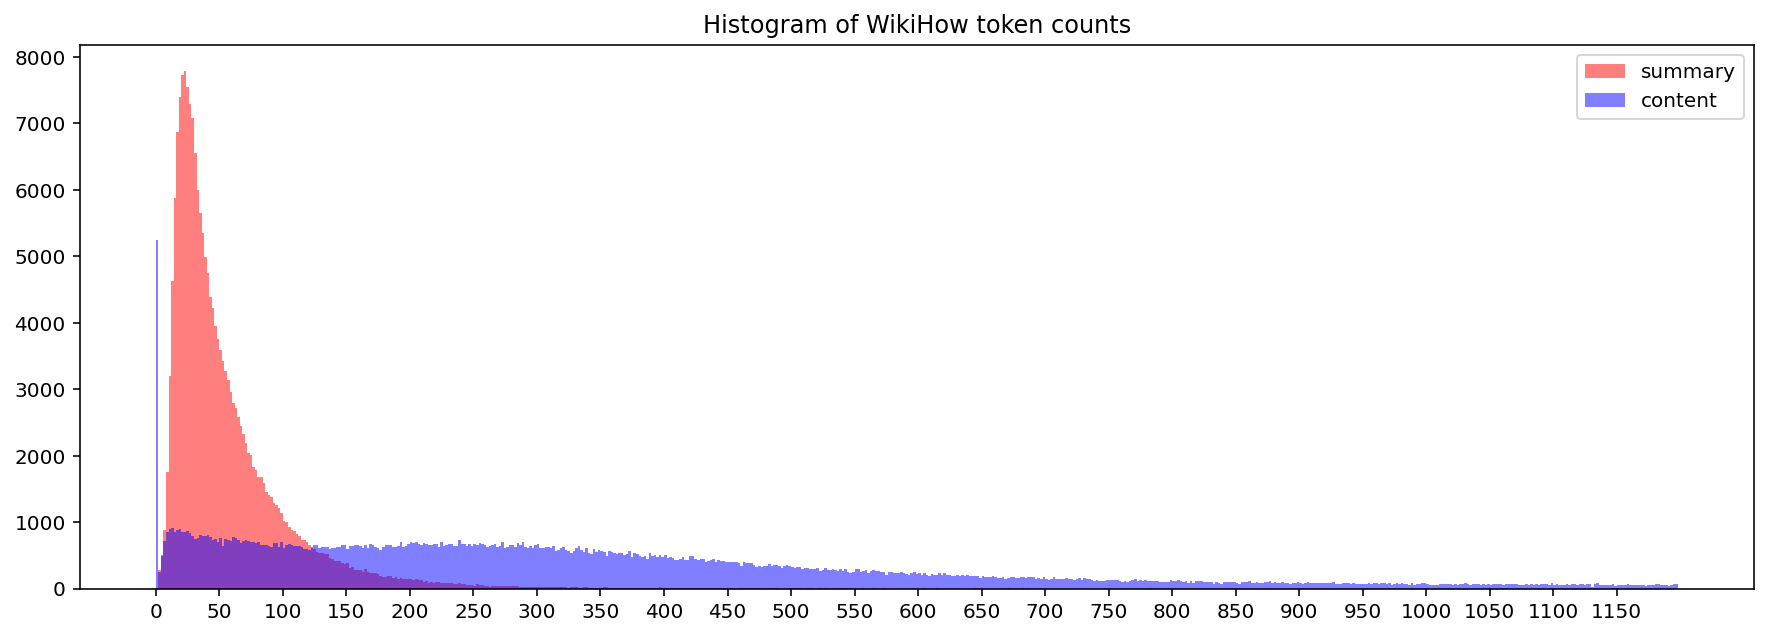

In [26]:
min_count = 0
max_count = 1200
plt.figure(figsize=(15,5))
bins = np.linspace(min_count, max_count, 600, endpoint=False, dtype=int)
plt.hist(wiki_pdf.where(wiki_pdf.content_token_count < max_count).summary_token_count, bins = bins, color='red', alpha=0.5, label='summary', log=False)
plt.hist(wiki_pdf.where(wiki_pdf.content_token_count < max_count).content_token_count, bins = bins, color='blue', alpha=0.5, label='content', log=False)
plt.legend()
plt.xticks(np.arange(min_count, max_count, 50))

plt.title("Histogram of WikiHow token counts")
plt.show();

It looks like there are some articles with no content. We'll have to clean that up if we use this dataset going forward. 